In [11]:
from backend.image import Image, Marker, MarkerRectangle2D, MarkerFill2D, MarkerContainer
from backend.filters import  filters_2dim as filters_2d
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from backend import MarkerMakerRectangle2DBinary, Accuracy, Segmentation, Evaluator, MarkerBorder2D
import os
from directory import Directory

In [13]:
PATH_TO_IMG_FOLDER = 'C:/Users/maxxx/VSprojects/back/0/0'
PATH_TO_BORDER_IMG = r'C:\Users\maxxx\VSprojects\back\0\0\border\border00001.png'

FOLDER = Directory(main_path=PATH_TO_IMG_FOLDER)   # Хранилище названий изображений по папкам

### Загрузка снимка низкого качества, отображение разметки для обучения, выделение границы, которую не нужно учитывать при расчете метрик

instances of class 1 = (606176,)
instances of class 0 = (393824,)


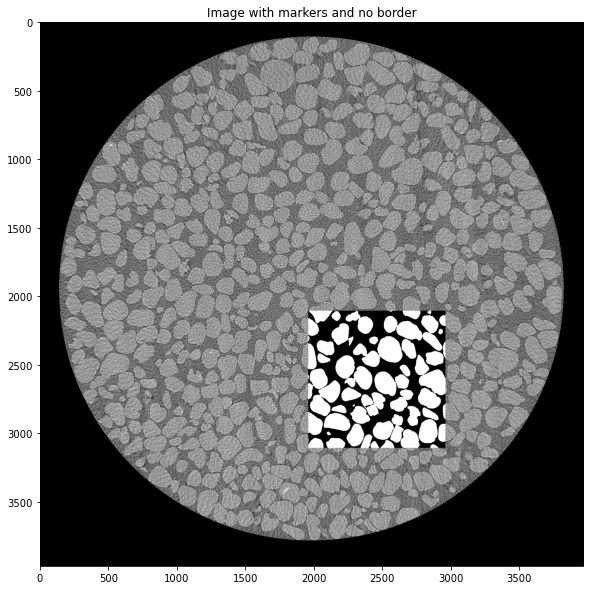

In [19]:
image = Image(path_to_image=FOLDER.ang_dec_folder[0])

point1 = (1957, 2106)
point2 = (1957 + 1000, 2106 + 1000)

markers = MarkerMakerRectangle2DBinary(FOLDER.segmented_folder[0], *point1, *point2).get_markers()
for marker in markers:
    image.draw_marker(marker, color=marker.value * 255)

border_marker = MarkerBorder2D(Image(path_to_image=PATH_TO_BORDER_IMG))
image.draw_marker(border_marker, color=0)
image.show(title="Image with markers and no border") 
image.reset()

### Применение 2д фильтров, сегментация, расчет accuracy

Appplying filters...
Making train data...
Fitting model...
Making predictions...


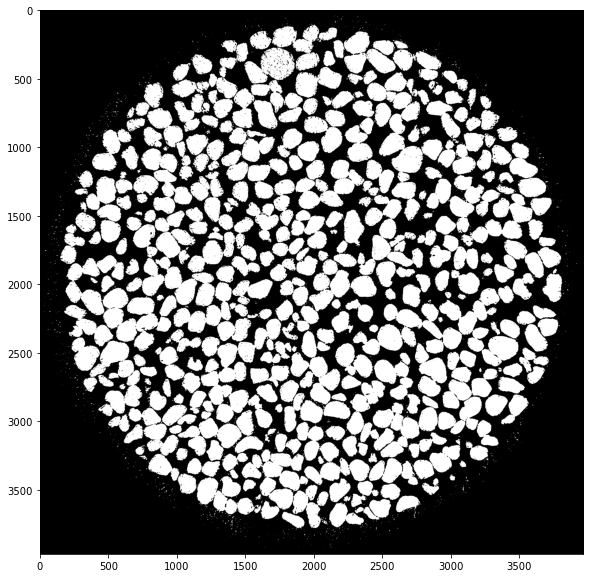

{'Accuracy': 0.9636443045731675}

In [21]:
filters =[filters_2d.MedianFilter(size=5), filters_2d.GaussianFilter(15), filters_2d.LaplacianDifference(),
                              filters_2d.BaseFilter2D()]

# filters = [filters_2d.BaseFilter2D()]  # use img pixels

sgm = Segmentation(model=LogisticRegression(), filters=filters)
result = sgm.fit_and_predict(image, markers)
result.show()

ground_truth = Image(path_to_image=PATH_TO_SEGMENTED, dim=2)
Evaluator.evaluate(result, ground_truth, markers, border_marker, Accuracy)

### Применение обученной модели на 100 2д срезов исходного 3д снимка

In [22]:
from tqdm.notebook import tqdm
from backend import Image3D
sgm.informing = False

In [8]:
img_3d           = Image3D(img_pathes = FOLDER.binning_folder)
img_3d_segmented = Image3D(img_pathes = FOLDER.segmented_folder)

print(f'3D Image shape = {img_3d.shape}')

sum_acc = 0
n = 0

for img_indx in tqdm(range(len(img_3d))):
    if img_indx != 0:
        img_2d_slice = img_3d[img_indx]
        result = sgm.predict(image = img_2d_slice)
        ground_truth = Image(path_to_image=img_3d_segmented.img_pathes[img_indx], dim=2)
        
        acc = Evaluator.evaluate(result, ground_truth, [], border_marker, Accuracy)[Accuracy.name]
        
        print(f'Accuracy at step {img_indx} = {acc}')
        sum_acc += acc
        n += 1
    
print(f'Mean accuracy = {sum_acc / n} per {n} images')

3D Image shape = (100, 3968, 3968)


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy at step 1 = 0.9595103454116053
Accuracy at step 2 = 0.9618721478372961
Accuracy at step 3 = 0.9598625316384234
Accuracy at step 4 = 0.9538434686062157
Accuracy at step 5 = 0.9599085426095466
Accuracy at step 6 = 0.9619215461191769
Accuracy at step 7 = 0.9596442382784934
Accuracy at step 8 = 0.953754457606865
Accuracy at step 9 = 0.9601109344273092
Accuracy at step 10 = 0.962367824311482
Accuracy at step 11 = 0.9601331401311642
Accuracy at step 12 = 0.9535993940477423
Accuracy at step 13 = 0.9598946169986545
Accuracy at step 14 = 0.9621700430000282
Accuracy at step 15 = 0.9600517505810179
Accuracy at step 16 = 0.9543455433340547
Accuracy at step 17 = 0.9605817706226065
Accuracy at step 18 = 0.9628041287554455
Accuracy at step 19 = 0.9608863463148881
Accuracy at step 20 = 0.9550194299908731
Accuracy at step 21 = 0.9610635214859004
Accuracy at step 22 = 0.9631888708023222
Accuracy at step 23 = 0.9609113747777077
Accuracy at step 24 = 0.9542635892321155
Accuracy at step 25 = 0.960

In [10]:
print(f'Mean accuracy = {round(sum_acc / n, 3)} per {n} images')

Mean accuracy = 0.959 per 99 images
